In [1]:
import matplotlib.pyplot as plt
from gym_anytrading.envs import StocksEnv
from finta import TA
import random
import tensorflow as tf
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns

random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

2024-04-19 23:42:07.101184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 23:42:08.320103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [47]:
tickers_negro = [
    ("NVDA", "2012-01-01", "2023-12-31"),
    ("INTC", "2012-01-01", "2023-12-31"),
    ("FRT", "2012-01-01", "2023-12-31"),
    ("NKE", "2012-01-01", "2023-12-31"),
    ("TSM", "2012-01-01", "2023-12-31"),
    ("USB", "2012-01-01", "2023-12-31"),
    ("XOM", "2012-01-01", "2023-12-31"),
    ("BA", "2012-01-01", "2023-12-31"),
    ("NEM", "2012-01-01", "2023-12-31"),
    ("HBAN", "2012-01-01", "2023-12-31"),
    ("VZ", "2012-01-01", "2023-12-31"),
    ("PCG", "2012-01-01", "2023-12-31"),
    ("FCX", "2012-01-01", "2023-12-31"),
    ("C", "2012-01-01", "2023-12-31"),
    ("OXY", "2012-01-01", "2023-12-31"),
    ("KEY", "2012-01-01", "2023-12-31"),
    ("WFC", "2012-01-01", "2023-12-31"),
    ("MRO", "2012-01-01", "2023-12-31"),
    # ("GOOGL", "2012-01-01", "2023-12-31"),
    ("NFLX", "2012-01-01", "2023-12-31"),
    ("HDB", "2012-01-01", "2023-12-31"),
    ("MU", "2012-01-01", "2023-12-31"),
    ("AVY", "2012-01-01", "2023-12-31"),
    ("MET", "2012-01-01", "2023-12-31"),
    ("MSTR", "2012-01-01", "2023-12-31"),
    ("WMB", "2012-01-01", "2023-12-31"),
    ("BSX", "2012-01-01", "2023-12-31"),
    ("EBAY", "2012-01-01", "2023-12-31"),
    ("SO", "2012-01-01", "2023-12-31"),
    ("CTSH", "2012-01-01", "2023-12-31"),
    ("BBWI", "2012-01-01", "2023-12-31"),
    ("V", "2012-01-01", "2023-12-31"),
    ("VFC", "2012-01-01", "2023-12-31"),
    ("MOS", "2012-01-01", "2023-12-31"),
    ("CRM", "2012-01-01", "2023-12-31"),
    ("SCHW", "2012-01-01", "2023-12-31"),
    ("CNP", "2012-01-01", "2023-12-31"),
    ("MDT", "2012-01-01", "2023-12-31"),
    ("EXC", "2012-01-01", "2023-12-31"),
    ("MTCH", "2012-01-01", "2023-12-31"),
    ("PARA", "2012-01-01", "2023-12-31"),
    ("UAL", "2012-01-01", "2023-12-31"),
    ("JNJ", "2012-01-01", "2023-12-31"),
    ("LUV", "2012-01-01", "2023-12-31"),
    ("MCD", "2012-01-01", "2023-12-31"),
    ("JPM", "2012-01-01", "2023-12-31"),
    ("GILD", "2012-01-01", "2023-12-31"),
    ("CVS", "2012-01-01", "2023-12-31"),
    ("ORCL", "2012-01-01", "2023-12-31"),
    ("UHS", "2012-01-01", "2023-12-31")
]
len(tickers_negro)

49

RSI

In [3]:
datas = {}

for k,i in enumerate(tickers_negro): 
    datas[i[0]] = yf.download(i[0], start=i[1], end= i[2],interval="1d")

    # prices = np.array(data['Adj Close'].values) #Adj Close prices
    dates = np.array(datas[i[0]].index.values).astype('datetime64[ns]') #Dates
    datas[i[0]]['rsi'] = TA.RSI(datas[i[0]],14,column='adj close') #Relative Strength Index (RSI)
    datas[i[0]]['macd'] = TA.MACD(datas[i[0]],column='adj close')['MACD'] #MACD Line
    datas[i[0]]['macd_signal'] = TA.MACD(datas[i[0]], column='adj close')['SIGNAL'] #MACD Signal Line
    # datas[i[0]]['bb_bbm'] = TA.BBANDS(datas[i[0]], column='adj close')['BB_MIDDLE'] #Bollinger Bands (BB) middle band (BBM)
    datas[i[0]]['bb_bbu'] = TA.BBANDS(datas[i[0]], column='adj close')['BB_UPPER'] #Bollinger Bands (BB) upper band (BBU)
    datas[i[0]]['bb_bbl'] = TA.BBANDS(datas[i[0]],column='adj close')['BB_LOWER'] #Bollinger Bands (BB) lower band (BBL)
    # datas[i[0]]['bb_width'] = TA.BBWIDTH(datas[i[0]],column='adj close') #Bollinger Bands (BB) width
    datas[i[0]]['obv'] = TA.OBV(datas[i[0]],'adj close') #On Balance Volume (OBV)
    # datas[i[0]]['from'] = pd.DataFrame([k] * len(datas[i[0]]))
    
    datas[i[0]].fillna(0, inplace=True)
    datas[i[0]] = datas[i[0]][datas[i[0]].index > '2013-01-01']
    datas[i[0]]
    
df= pd.concat([df for df in datas.values()], axis=0)
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Open,High,Low,Close,Adj Close,Volume,rsi,macd,macd_signal,bb_bbu,bb_bbl,obv
Date,,,,,,,,,,,,
2013-01-02,3.140000,3.182500,3.127500,3.180000,2.935840,47883600,60.223783,0.011304,0.011125,3.206539,2.971461,-390527600.0
2013-01-03,3.180000,3.217500,3.145000,3.182500,2.938148,29888800,60.423367,0.017204,0.012340,3.216986,2.976764,-360638800.0
2013-01-04,3.187500,3.297500,3.177500,3.287500,3.035087,52496800,67.742590,0.029362,0.015745,3.246299,2.977201,-308142000.0
2013-01-07,3.285000,3.295000,3.170000,3.192500,2.947381,61073200,57.399463,0.031557,0.018907,3.249990,2.993260,-369215200.0
2013-01-08,3.200000,3.210000,3.100000,3.122500,2.882756,46642400,51.196719,0.027762,0.020678,3.243191,3.013309,-415857600.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,151.500000,153.570007,151.250000,153.080002,152.890701,382700,71.002013,5.003540,4.321617,156.466951,129.343047,71061900.0
2023-12-26,153.279999,155.179993,152.630005,154.130005,153.939407,288000,72.122511,5.169724,4.491238,157.901990,129.598008,71349900.0
2023-12-27,153.929993,153.949997,151.699997,152.610001,152.421280,374400,68.024728,5.119908,4.616972,158.752434,130.400564,70975500.0


In [4]:
data = yf.download('GOOG', start='2012-01-01', end='2023-12-31' ,interval="1d")
prices = np.array(data['Adj Close'].values) #Adj Close prices

dates = np.array(data.index.values).astype('datetime64[ns]') #Dates
data['rsi'] = TA.RSI(data,14,column='adj close') #Relative Strength Index (RSI)
data['macd'] = TA.MACD(data,column='adj close')['MACD'] #MACD Line
data['macd_signal'] = TA.MACD(data, column='adj close')['SIGNAL'] #MACD Signal Line
# data['bb_bbm'] = TA.BBANDS(data, column='adj close')['BB_MIDDLE'] #Bollinger Bands (BB) middle band (BBM)
data['bb_bbu'] = TA.BBANDS(data, column='adj close')['BB_UPPER'] #Bollinger Bands (BB) upper band (BBU)
data['bb_bbl'] = TA.BBANDS(data,column='adj close')['BB_LOWER'] #Bollinger Bands (BB) lower band (BBL)
# data['bb_width'] = TA.BBWIDTH(data,column='adj close') #Bollinger Bands (BB) width
data['obv'] = TA.OBV(data,'adj close') #On Balance Volume (OBV)

data.fillna(0, inplace=True)
data = data[data.index > '2013-01-01']
len(data)

[*********************100%%**********************]  1 of 1 completed


2768

<Axes: >

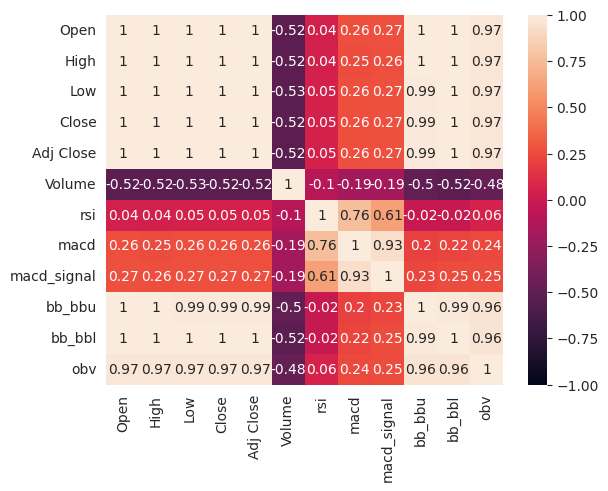

In [8]:
#round to 2 decimals heatmap
sns.heatmap(data.corr('spearman').round(2), annot=True,vmin=-1,vmax=1)

## Enviroment

In [10]:
from enum import Enum
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Adj Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['Adj Close','rsi','Volume','macd','macd_signal','bb_bbu','bb_bbl','obv']].to_numpy()[start:end]
    return prices, signal_features

def reward_function(env, action):
    step_reward = 0

    class Positions(Enum):
        Short = 0
        Long = 1

    trade = False
    if (
            (action == Actions.Buy.value and env._position == Positions.Short) or
            (action == Actions.Sell.value and env._position == Positions.Long)
    ):
        trade = True

    if trade:
        current_price = env.prices[env._current_tick]
        last_trade_price = env.prices[env._last_trade_tick]
        price_diff = current_price - last_trade_price

        # Penalizar o recompensar en base a la magnitud de la diferencia de precios
        if price_diff > 0:  # Si se gana dinero
            step_reward += 0.5 * price_diff  # Multiplicador arbitrario para ajustar la importancia
        else:  # Si se pierde dinero
            step_reward += 1.5 * price_diff  # Multiplicador arbitrario para ajustar la importancia

    return step_reward



In [11]:
class customEnv(StocksEnv):
    """
    Custom Environment for RL trading
    """
    _process_data = add_signals    

    # _calculate_reward = reward_function


train

In [13]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

env = customEnv(df=data, window_size=30, frame_bound=(30, len(data)))
env.trade_fee_ask_percent = 0
env.trade_fee_bid_percent = 0
env.reset(seed=42)
env = Monitor(env, './logs_v2')  # Envolver con Monitor wrapper
env_maker = lambda: env
env_train = DummyVecEnv([env_maker])
#add dqn
model = A2C(policy='MlpPolicy', env=env_train, verbose=1)

eval_callback = EvalCallback(env_train, best_model_save_path='./logs_v2/',
                             log_path='./logs_v2/', eval_freq=500,
                             deterministic=True, render=False)

model.learn(total_timesteps=500000,callback=eval_callback)

Using cuda device


In [104]:
model.save('RL_del_gran_pisky_model_callback_2.h5')

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Evaluation

In [18]:
from stable_baselines3.common.evaluation import evaluate_policy
#load model
from stable_baselines3 import A2C
env_test = DummyVecEnv([lambda: env])
model = A2C.load('./logs_v2/best_model.zip')
mean_reward_trained = evaluate_policy(model, env_test, n_eval_episodes=10)
mean_reward_trained

(128.51976999999997, 2.842170943040401e-14)

In [17]:
# Crear el entorno de entrenamiento
env_train = DummyVecEnv([lambda: env])
model_untrained = A2C('MlpPolicy', env_train, verbose=1)
mean_reward_untrained = evaluate_policy(model_untrained, env_test, n_eval_episodes=10)
mean_reward_untrained

Using cuda device


(1.85231, 0.0)

In [38]:

data = yf.download('NVDA', start='2012-01-01', end= '2024-01-01',interval="1d")
prices = np.array(data['Adj Close'].values) #Adj Close prices
dates = np.array(data.index.values).astype('datetime64[ns]') #Dates
data['rsi'] = TA.RSI(data,14,column='adj close') #Relative Strength Index (RSI)
data['macd'] = TA.MACD(data,column='adj close')['MACD'] #MACD Line
data['macd_signal'] = TA.MACD(data, column='adj close')['SIGNAL'] #MACD Signal Line
# data['bb_bbm'] = TA.BBANDS(data, column='adj close')['BB_MIDDLE'] #Bollinger Bands (BB) middle band (BBM)
data['bb_bbu'] = TA.BBANDS(data, column='adj close')['BB_UPPER'] #Bollinger Bands (BB) upper band (BBU)
data['bb_bbl'] = TA.BBANDS(data,column='adj close')['BB_LOWER'] #Bollinger Bands (BB) lower band (BBL)
# data['bb_width'] = TA.BBWIDTH(data,column='adj close') #Bollinger Bands (BB) width
data['obv'] = TA.OBV(data,'adj close') #On Balance Volume (OBV)

data.fillna(0, inplace=True)
data = data[data.index > '2013-01-01']
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,rsi,macd,macd_signal,bb_bbu,bb_bbl,obv
Date,,,,,,,,,,,,
2013-01-02,3.140000,3.182500,3.127500,3.180000,2.935841,47883600,60.223832,0.011304,0.011125,3.206539,2.971461,-3.905276e+08
2013-01-03,3.180000,3.217500,3.145000,3.182500,2.938148,29888800,60.423332,0.017204,0.012340,3.216986,2.976764,-3.606388e+08
2013-01-04,3.187500,3.297500,3.177500,3.287500,3.035086,52496800,67.742438,0.029362,0.015745,3.246299,2.977201,-3.081420e+08
2013-01-07,3.285000,3.295000,3.170000,3.192500,2.947381,61073200,57.399451,0.031557,0.018907,3.249990,2.993260,-3.692152e+08
2013-01-08,3.200000,3.210000,3.100000,3.122500,2.882756,46642400,51.196695,0.027762,0.020678,3.243191,3.013309,-4.158576e+08
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,491.950012,493.829987,484.670013,488.299988,488.277069,25213900,55.352110,6.346404,5.646942,502.425803,452.217193,9.390777e+09
2023-12-26,489.679993,496.000000,489.600006,492.790009,492.766907,24420000,57.245990,6.559877,5.829529,503.803958,451.876038,9.415197e+09
2023-12-27,495.109985,496.799988,490.850006,494.170013,494.146820,23364800,57.837933,6.762449,6.016113,505.612331,451.663667,9.438562e+09


In [57]:
from gym_anytrading.envs import Actions

env_test = customEnv(df=data, window_size=30, frame_bound=(30,len(data)))

obs,_ = env_test.reset(seed=42)
env_test.trade_fee_ask_percent = 0
env_test.trade_fee_bid_percent = 0

r= []
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
buy_rsi = []
sell_rsi = []

while True:
    actual_lt= env_test._last_trade_tick
    obs = obs[np.newaxis, ...] 
    action, _states = model.predict(obs)
    action_stats[Actions(action)] += 1
    obs, rewards,_ , done, info= env_test.step(action)
    r.append(rewards)
    if done:
        print("info",info)
        break
        
        

info {'total_reward': 396.63627576828003, 'total_profit': 20.144039383545255, 'position': <Positions.Long: 1>}


In [27]:
env_test.max_possible_profit() #se obtiene el maximo profit posible

1.2195294534385883

OPTUNA

In [28]:
env_test.signal_features[env_test._current_tick] #obtener los valores del dia que se va a predecir

array([2.69099998e+01, 6.11028106e+01, 2.84508000e+07, 1.03128389e+00,
       1.31217636e+00, 2.77765625e+01, 2.51962944e+01, 5.81099400e+08])

In [29]:
print("env information:")
print("> shape:", env_test.unwrapped.shape)
print("> df.shape:", env_test.unwrapped.df.shape)
print("> prices.shape:", env_test.unwrapped.prices.shape)
print("> signal_features.shape:", env_test.unwrapped.signal_features.shape)
print("> max_possible_profit:", env_test.unwrapped.max_possible_profit())


env information:
> shape: (30, 8)
> df.shape: (2768, 12)
> prices.shape: (50,)
> signal_features.shape: (50, 8)
> max_possible_profit: 1.2195294534385883


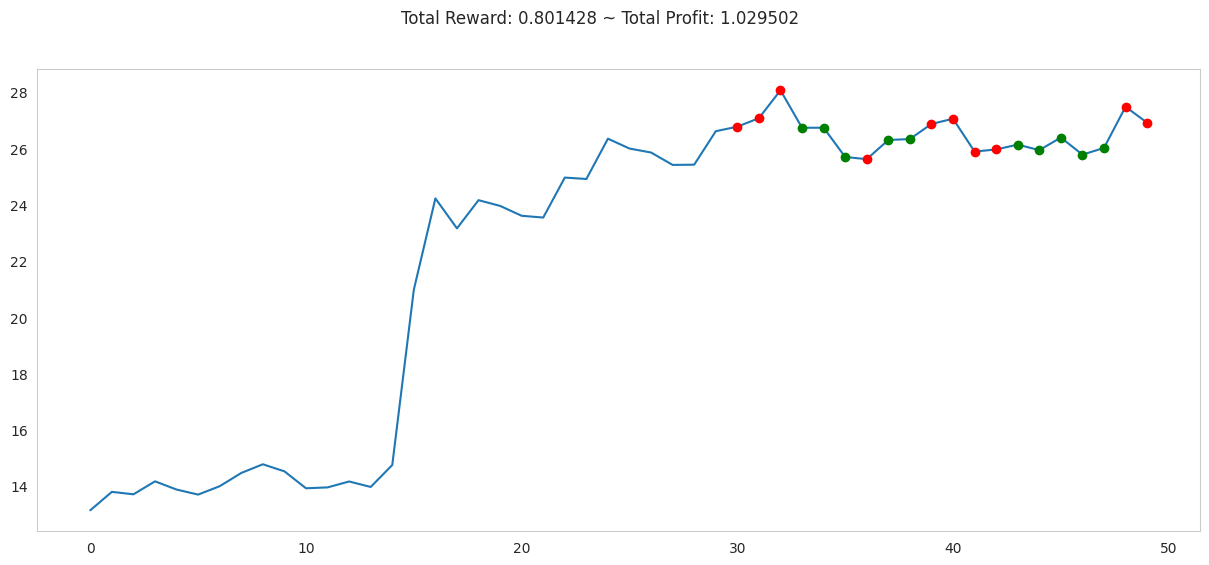

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.cla()
env_test.render_all()
plt.grid()
plt.show()

In [31]:
print(r)

[0, 0, 0, 0, 0, -1.1142845153808594, 0, 0, 0.5699996948242188, 0, 0, 0, 0, 0, 0, 0, 0, 1.345712661743164, 0]


## Graficos

/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior

                           Strategy
-------------------------  ----------
Start Period               2013-02-19
End Period                 2023-12-29
Risk-Free Rate             0.0%
Time in Market             11.0%

Cumulative Return          2,180.29%
CAGR﹪                     21.99%

Sharpe                     0.91
Prob. Sharpe Ratio         99.89%
Smart Sharpe               0.91
Sortino                    1.58
Smart Sortino              1.57
Sortino/√2                 1.12
Smart Sortino/√2           1.11
Omega                      1.86

Max Drawdown               -71.81%
Longest DD Days            759
Volatility (ann.)          40.55%
Calmar                     0.31
Skew                       1.98
Kurtosis                   87.32

Expected Daily %           0.11%
Expected Monthly %         2.42%
Expected Yearly %          32.88%
Kelly Criterion            25.49%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.05%
Expected Shortfall (cVaR)  -4.05%

Max Consecutive Wins 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-12-01,2022-05-16,2023-12-29,759,-71.808120,-70.517524
2,2018-08-24,2018-12-21,2019-04-18,238,-31.220261,-25.935952
3,2015-12-07,2016-09-21,2017-01-31,422,-28.503736,-28.201750
4,2014-04-15,2014-05-05,2015-01-22,283,-26.131016,-25.839297
5,2019-08-02,2019-10-28,2020-04-21,264,-23.024572,-22.786482


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


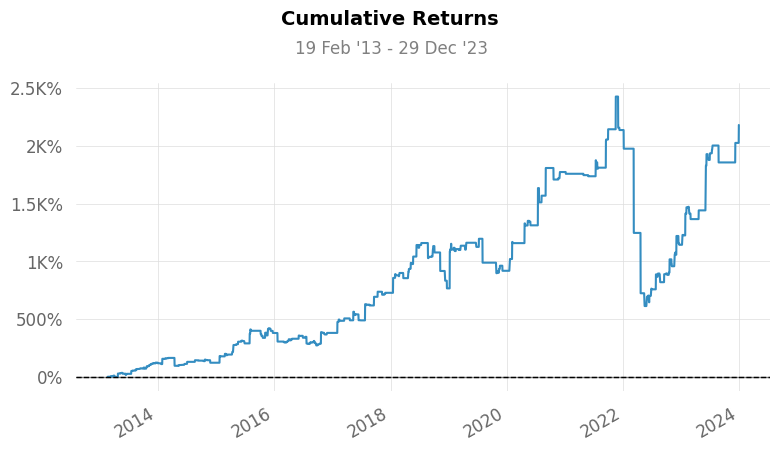

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


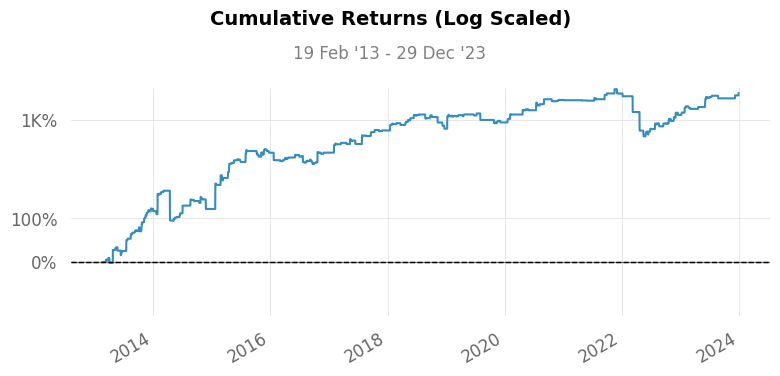

/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


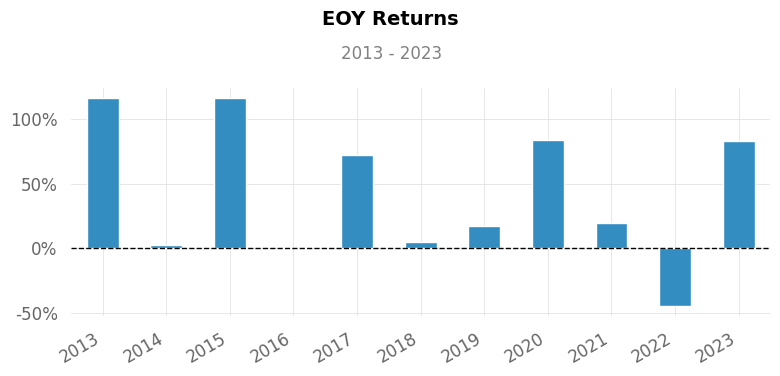

/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/quantstats/_plotting/core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


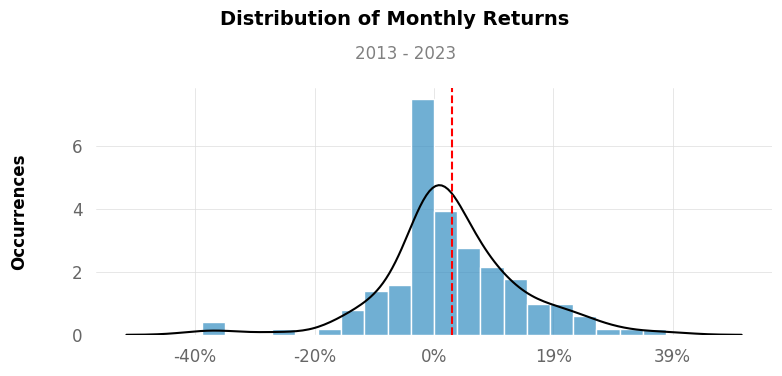

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


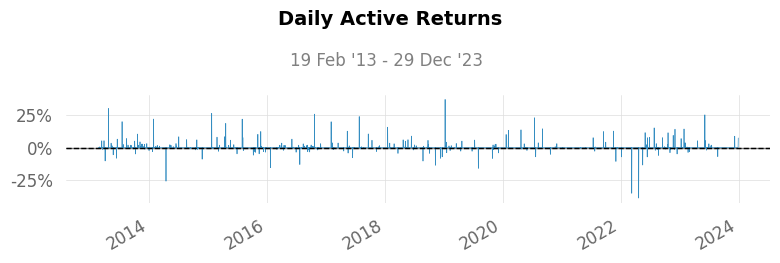

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


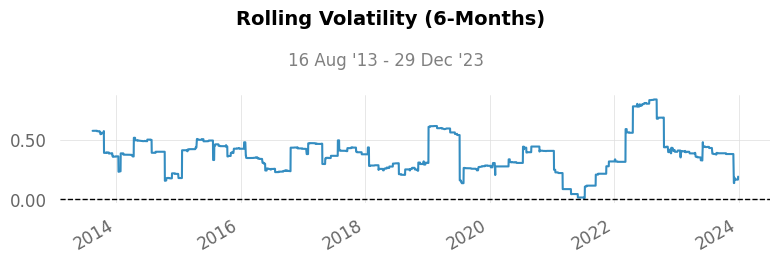

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


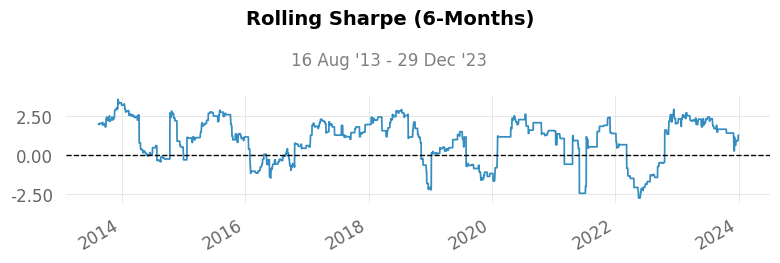

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


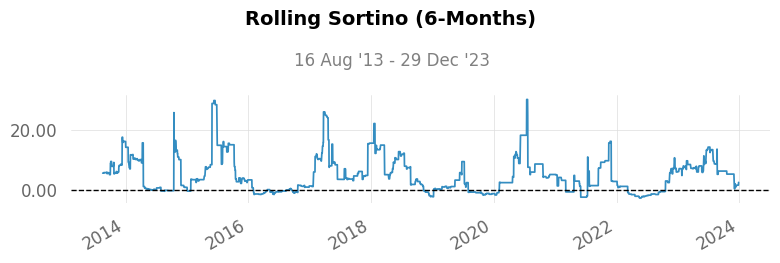

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


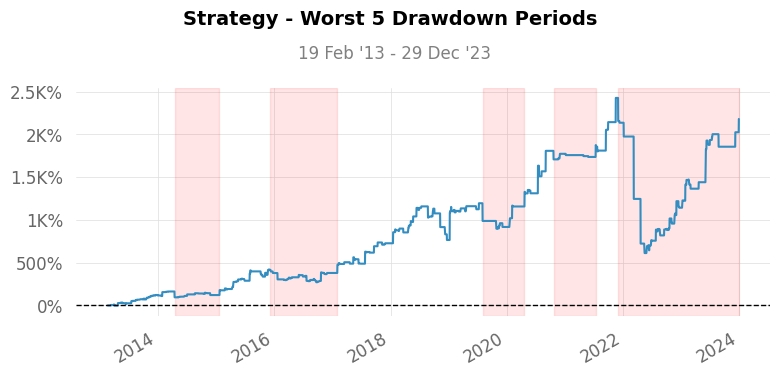

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


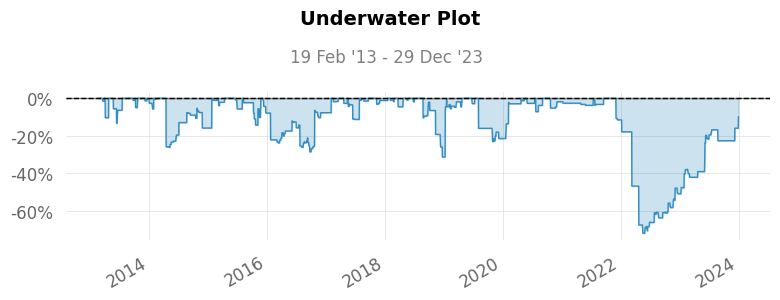

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


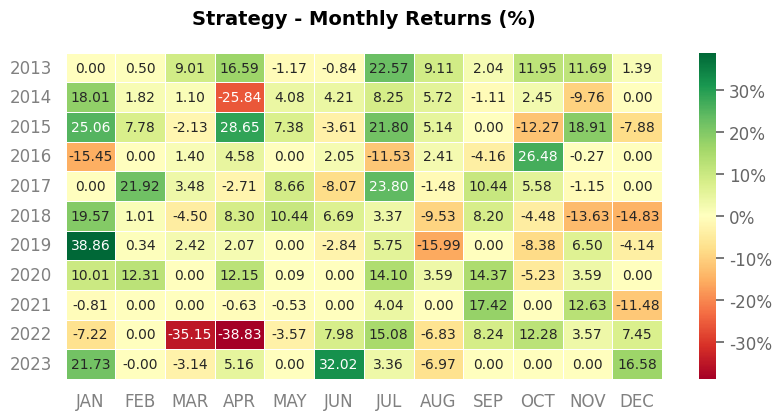

/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/quantstats/_plotting/core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/quantstats/_plotting/core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/quantstats

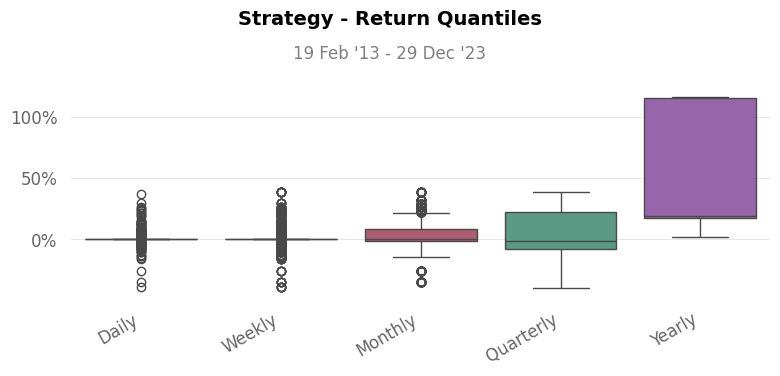

/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/pisky/PyCharm enviroments/mem-ind/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior

In [202]:
import quantstats as qs

window_size = 30
start_index = window_size
end_index = len(data)

qs.extend_pandas()

net_worth = pd.Series(env_test.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')

dict_keys([])